In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
path='/kaggle/input/final-data/Final_data.csv'

In [3]:
df=pd.read_csv(path)
ts=df['Total Demand (as recorded)']
ts

0         2664.281900
1         2698.868767
2         2710.682853
3         2696.470040
4         2666.727600
             ...     
262747    5136.024902
262748    5165.746387
262749    5104.936882
262750    5071.101107
262751    4985.896029
Name: Total Demand (as recorded), Length: 262752, dtype: float64

In [4]:
ts_diff1 = ts.dropna()
ts_diff1

0         2664.281900
1         2698.868767
2         2710.682853
3         2696.470040
4         2666.727600
             ...     
262747    5136.024902
262748    5165.746387
262749    5104.936882
262750    5071.101107
262751    4985.896029
Name: Total Demand (as recorded), Length: 262752, dtype: float64

In [5]:
ts_diff1 = ts.dropna()
ts_diff1_array = ts_diff1.values.reshape(-1, 1)
len(ts_diff1_array)

262752

In [6]:
import numpy as np

def create_sequences(data, past_window, future_window):
    X, y = [], []
    for i in range(len(data) - past_window - future_window):
        X.append(data[i:i + past_window])  # Past 672 timestamps
        y.append(data[i + past_window:i + past_window + future_window])  # Next 96 timestamps
    return np.array(X), np.array(y)

# Define past and future window
past_window = 7 * 96  # 672 timesteps (7 days)
future_window = 96  # 96 timesteps (1 day)

# Create sequences
X, y = create_sequences(ts_diff1_array, past_window, future_window)

print("Shape of X:", X.shape)  # (samples, 672, 1) -> Input for DA-RNN Encoder
print("Shape of y:", y.shape)  # (samples, 96, 1) -> Output for Decoder


Shape of X: (261984, 672, 1)
Shape of y: (261984, 96, 1)


In [7]:
train_size = int(0.7 * len(X))  # 70% train
val_size = int(0.2 * len(X))   # 15% validation
test_size = len(X) - train_size - val_size  # Remaining 15% for test

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
# Scale data

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (183388, 672, 1) (183388, 96, 1)
Validation: (52396, 672, 1) (52396, 96, 1)
Test: (26200, 672, 1) (26200, 96, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

# Transform validation and test data using the same scaler (DO NOT FIT AGAIN)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)


In [ ]:
Screenshot 2025-04-04 093456.png

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    """Encoder for DA-RNN"""
    def __init__(self, input_size, encoder_num_hidden, T):
        super(Encoder, self).__init__()
        self.T = T
        self.encoder_num_hidden = encoder_num_hidden

        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=encoder_num_hidden,
                                  batch_first=True)

    def forward(self, X):
        # X shape: (batch_size, T, features)
        _, (h_n, c_n) = self.lstm_layer(X)
        return h_n, c_n

class Decoder(nn.Module):
    """Decoder for DA-RNN"""
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden, output_size):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T
        self.output_size = output_size  # Number of future steps to predict (96)

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )

        self.lstm_layer = nn.LSTM(
                            input_size=encoder_num_hidden + 1,  # Fix the input size
                            hidden_size=decoder_num_hidden,
                            batch_first=True
                        )


        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, output_size)

    def forward(self, X_encoded, y_prev):
        batch_size = X_encoded.shape[0]

        d_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)
        c_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)

        for t in range(y_prev.shape[1]):  # Ensure valid indexing

            x = torch.cat((d_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   c_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   X_encoded), dim=2)

            seq_len = X_encoded.shape[1]  # Ensure sequence length is correct
            beta = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, seq_len), dim=1)


            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]

            if t < self.T - 1:
                y_tilde = torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1)
                self.lstm_layer.flatten_parameters()
                _, (d_n, c_n) = self.lstm_layer(y_tilde.unsqueeze(1), (d_n, c_n))

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        return y_pred
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DA_rnn(nn.Module):
    """DA-RNN model"""
    def __init__(self, X, y, X_val, y_val, X_test, y_test, T, encoder_num_hidden, decoder_num_hidden, batch_size, learning_rate, epochs,scaler_X,scaler_y):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.T = T
        
        # Store dataset
        self.X, self.y = X, y  # Training Data
        self.X_val, self.y_val = X_val, y_val  # Validation Data
        self.X_test, self.y_test = X_test, y_test  # Test Data
        self.output_size = y.shape[1]  # 96 time steps

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.Encoder = Encoder(input_size=X.shape[2],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)

        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T,
                               output_size=self.output_size).to(self.device)

        self.encoder_optimizer = optim.Adam(self.Encoder.parameters(), lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(self.Decoder.parameters(), lr=self.learning_rate)
        self.scaler_X= scaler_X
        self.scaler_y = scaler_y

    def mse_loss(self, y_pred, y_true):
        return torch.mean((y_true - y_pred) ** 2)
    def mean_absolute_percentage_error(self,y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    import matplotlib.pyplot as plt

    import matplotlib.pyplot as plt
    import numpy as np
    
    import numpy as np
    
    def evaluate(self, X_val, y_val, scaler):
        """Compute validation loss without updating weights, apply inverse scaling, and plot the first 600 points"""
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
            total_loss = 0
            iter_count = int(np.ceil(X_val.shape[0] / self.batch_size))
    
            while idx < X_val.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_val.shape[0]))
    
                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(X_val[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(y_val[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])
                total_loss += loss.item()
    
                # Store values for inverse scaling & plotting
                all_preds.append(y_pred.cpu().numpy())
                all_actuals.append(y_batch[:, -96:, 0].cpu().numpy())
    
                idx += self.batch_size
    
        # Flatten arrays
        y_pred_np = np.concatenate(all_preds).flatten()
        y_actual_np = np.concatenate(all_actuals).flatten()
    
        # Apply inverse scaling
        y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        # Select first 600 points
        y_pred_np = y_pred_np[:600]
        y_actual_np = y_actual_np[:600]
    
        # Compute MAPE loss
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape:.2f}%")
    
        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(y_actual_np, label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        return total_loss / iter_count




    def train(self):
        iter_per_epoch = int(np.ceil(self.X.shape[0] / self.batch_size))
        self.epoch_losses = np.zeros(self.epochs)
        min_val_loss = float('inf')  # Initialize minimum validation loss

        for epoch in range(self.epochs):
            idx = 0
            epoch_loss = 0

            self.Encoder.train()
            self.Decoder.train()

            while idx < self.X.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X.shape[0]))

                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(self.X[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y[indices], dtype=torch.float32).to(self.device)

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])

                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])

                loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                epoch_loss += loss.item()
                idx += self.batch_size

            avg_epoch_loss = epoch_loss / iter_per_epoch
            self.epoch_losses[epoch] = avg_epoch_loss

            # Compute validation loss
            val_loss = self.evaluate(self.X_val, self.y_val,self.scaler_y)

            # Save best model based on validation loss
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(self.state_dict(), '/kaggle/working/best_model.pth')
                print(f"Epoch {epoch}: New best model saved with validation loss {min_val_loss:.4f}")

            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    def test(self):
        """Test the model on test data"""
        # Convert NumPy arrays to tensors
        X_test = torch.tensor(self.X_test, dtype=torch.float32).to(self.device)
        y_test = torch.tensor(self.y_test, dtype=torch.float32).to(self.device)
    
        self.Encoder.eval()
        self.Decoder.eval()
    
        with torch.no_grad():
            h_n, c_n = self.Encoder(X_test)
            y_pred = self.Decoder(h_n.permute(1, 0, 2), y_test[:, :-1, 0])
    
        return y_pred.cpu().numpy(), y_test.cpu().numpy()

# Define dataset shapes

num_samples = 183388
T = 96  # Input sequence length
future_steps = 96  # Prediction steps

# X = np.random.randn(num_samples, T, 1)  # Shape: (samples, T, features)
# y = np.random.randn(num_samples, future_steps, 1)  # Shape: (samples, future_steps, targets)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize DA-RNN with multi-step output
# model = DA_rnn(X_tensor, y_tensor, T=T,
#                encoder_num_hidden=64,
#                decoder_num_hidden=64,
#                batch_size=128,
#                learning_rate=0.001,
#                epochs=50)
model = DA_rnn(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, T=T, encoder_num_hidden=64, decoder_num_hidden=64, batch_size=128, learning_rate=0.001, epochs=50,scaler_X=scaler_X,scaler_y=scaler_y)


model.load_state_dict(torch.load("/kaggle/input/final_model/pytorch/default/1/best_model (5).pth"))


<ipython-input-21-d0dc1c6703f4>:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/final_model/pytorch/default/1/best_model (

<All keys matched successfully>

In [26]:
model.train()

Epoch 0: New best model saved with validation loss 0.0239
Epoch 0/50, Train Loss: 3.6966, Val Loss: 0.0239
Epoch 1: New best model saved with validation loss 0.0085
Epoch 2: New best model saved with validation loss 0.0067
Epoch 2/50, Train Loss: 0.0079, Val Loss: 0.0067
Epoch 4/50, Train Loss: 0.0077, Val Loss: 0.0083
Epoch 6/50, Train Loss: 0.0076, Val Loss: 0.0095
Epoch 8/50, Train Loss: 0.0077, Val Loss: 0.0093
Epoch 10/50, Train Loss: 0.0076, Val Loss: 0.0091
Epoch 12/50, Train Loss: 0.0073, Val Loss: 0.0088
Epoch 14/50, Train Loss: 0.0071, Val Loss: 0.0086
Epoch 16: New best model saved with validation loss 0.0056
Epoch 16/50, Train Loss: 0.0053, Val Loss: 0.0056
Epoch 17: New best model saved with validation loss 0.0044
Epoch 18: New best model saved with validation loss 0.0035
Epoch 18/50, Train Loss: 0.0039, Val Loss: 0.0035
Epoch 19: New best model saved with validation loss 0.0031
Epoch 20: New best model saved with validation loss 0.0029
Epoch 20/50, Train Loss: 0.0029, Val

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

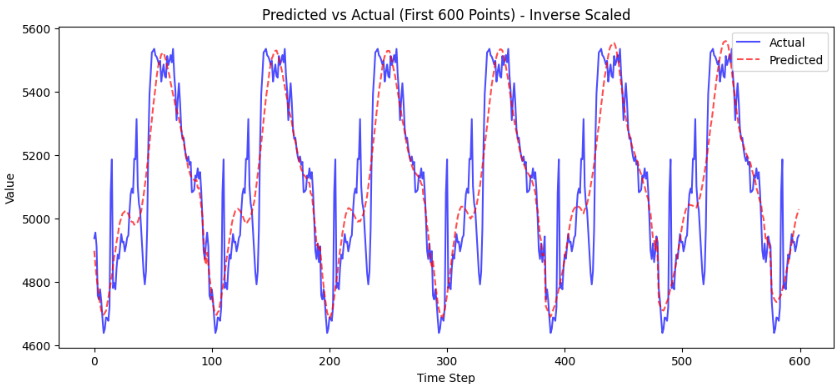

In [4]:
y_pred_np,y_actual_np = model.test(on_train=False)
y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
y_actual_np = scaler.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_actual_np, label="Actual", color="blue", alpha=0.7)
plt.plot(y_pred_np, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
plt.legend()
plt.show()

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
loss=mean_absolute_percentage_error(y_pred_np,y_actual_np)

print('MAPE Loss:',loss)

MAPE Loss: 5.52


In [23]:
torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

In [11]:
import torch
torch.cuda.empty_cache()


In [ ]:
# Reshape actual values and predictions for inverse transformation
y_test_reshaped = y_test_scaled.reshape(-1, 1)
test_preds_reshaped = test_preds.reshape(-1, 1)  # Assuming test_preds contains model predictions

# Inverse transform `y_test`
y_test_inv = scaler_y.inverse_transform(
    np.concatenate(
        (y_test_reshaped, np.zeros((y_test_reshaped.shape[0], y_train.shape[-1] - 1))), axis=1)
)[:, 0]  # Extract the first column (actual target values)

# Inverse transform `test_preds`
test_preds_inv = scaler_y.inverse_transform(
    np.concatenate(
        (test_preds_reshaped, np.zeros((test_preds_reshaped.shape[0], y_train.shape[-1] - 1))), axis=1)
)[:, 0]  # Extract the first column (predicted values)


In [17]:
torch.save(model.state_dict(), '/kaggle/working/best_model.pth')

In [31]:
model.epoch_losses

array([[0.8529, 0.7361, 0.6802, 0.6453, 0.6325],
       [0.6789, 0.6507, 0.6236, 0.6092, 0.5759],
       [0.5928, 0.5823, 0.5798, 0.5732, 0.5694],
       [0.5836, 0.5635, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [ ]:
# print("Epoch 0: New best model saved with loss 0.8529")


In [29]:
import numpy as np

model.epoch_losses = np.array([
    [0.8529, 0.7361, 0.6802, 0.6453, 0.6325],
    [0.6789, 0.6507, 0.6236, 0.6092, 0.5759],
    [0.5928, 0.5823, 0.5798, 0.5732, 0.5694],
    [0.5836, 0.5635, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])


In [30]:
model.epoch_losses

array([[0.8529, 0.7361, 0.6802, 0.6453, 0.6325],
       [0.6789, 0.6507, 0.6236, 0.6092, 0.5759],
       [0.5928, 0.5823, 0.5798, 0.5732, 0.5694],
       [0.5836, 0.5635, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    ]])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    """Encoder for DA-RNN"""
    def __init__(self, input_size, encoder_num_hidden, T):
        super(Encoder, self).__init__()
        self.T = T
        self.encoder_num_hidden = encoder_num_hidden

        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=encoder_num_hidden,
                                  batch_first=True)

    def forward(self, X):
        _, (h_n, c_n) = self.lstm_layer(X)
        return h_n, c_n

class Decoder(nn.Module):
    """Decoder for DA-RNN"""
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden, output_size):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T
        self.output_size = output_size  

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )

        self.lstm_layer = nn.LSTM(
            input_size=encoder_num_hidden + 1,
            hidden_size=decoder_num_hidden,
            batch_first=True
        )

        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, output_size)

    def forward(self, X_encoded, y_prev):
        batch_size = X_encoded.shape[0]
        d_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)
        c_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)

        for t in range(y_prev.shape[1]):  
            x = torch.cat((d_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   c_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   X_encoded), dim=2)

            seq_len = X_encoded.shape[1]  
            beta = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, seq_len), dim=1)
            
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]

            if t < self.T - 1:
                y_tilde = torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1)
                self.lstm_layer.flatten_parameters()
                _, (d_n, c_n) = self.lstm_layer(y_tilde.unsqueeze(1), (d_n, c_n))

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        return y_pred

class DA_rnn(nn.Module):
    """DA-RNN model"""
    def __init__(self, X, y, T, encoder_num_hidden, decoder_num_hidden, batch_size, learning_rate, epochs):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y
        self.output_size = y.shape[1]  

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.Encoder = Encoder(input_size=X.shape[2],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)

        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T,
                               output_size=self.output_size).to(self.device)

        self.criterion = nn.MSELoss()
        self.encoder_optimizer = optim.Adam(self.Encoder.parameters(), lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(self.Decoder.parameters(), lr=self.learning_rate)

    def train(self):
        iter_per_epoch = int(np.ceil(self.X.shape[0] / self.batch_size))
        self.epoch_losses = np.zeros(self.epochs)

        for epoch in range(self.epochs):
            idx = 0
            epoch_loss = 0
            while idx < self.X.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X.shape[0]))
                x_batch = self.X[indices].to(self.device)  
                y_batch = self.y[indices].to(self.device)  

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])  

                loss = self.criterion(y_pred, y_batch[:, -96:, 0])

                loss.backward()

                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                epoch_loss += loss.item()
                idx += self.batch_size

            self.epoch_losses[epoch] = epoch_loss / iter_per_epoch

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Loss: {self.epoch_losses[epoch]:.4f}")

    def test(self, on_train=True):
        test_indices = np.arange(0, int(self.X.shape[0] * 0.7)) if on_train else np.arange(int(self.X.shape[0] * 0.7), self.X.shape[0])
        X_test = self.X[test_indices].to(self.device)
        y_test = self.y[test_indices].to(self.device)

        with torch.no_grad():
            h_n, c_n = self.Encoder(X_test)
            y_pred = self.Decoder(h_n.permute(1, 0, 2), y_test[:, :-1, 0])

        return y_pred.cpu().numpy()

# Define dataset shapes
num_samples = 261983
T = 96  # Updated input sequence length
future_steps = 96  # Prediction steps

# X = np.random.randn(num_samples, T, 1)  # Shape: (samples, 96, features)
# y = np.random.randn(num_samples, future_steps, 1)  # Shape: (samples, 96, targets)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Initialize DA-RNN with updated sequence length
model = DA_rnn(X_tensor, y_tensor, T=T,
               encoder_num_hidden=64,
               decoder_num_hidden=64,
               batch_size=128,
               learning_rate=0.001,
               epochs=50)

# Train model
model.train()

# Get predictions
y_pred = model.test()


In [ ]:
y_train_pred = model.test(on_train=True)
y_test_pred = model.test(on_train=False)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_tensor)), y_tensor.numpy()[:, -1, 0], label="True Values")
plt.plot(range(T, len(y_train_pred) + T), y_train_pred[:, -1], label="Predicted - Train")
plt.plot(range(T + len(y_train_pred), len(y_tensor)), y_test_pred[:, -1], label="Predicted - Test")
plt.legend()
plt.show()

In [ ]:
df=pd.read_csv("/kaggle/input/file-1/file1.csv",low_memory=False)

,Timestamp,TPCODL Demand,TPWODL Demand,TPNODL Demand,TPSOSDL Demand,Total Demand (as recorded),Renewables Generation (SOLAR),Frequency,Vedanta Drawl,IMFA Drawl,Year
0,2017-01-01 00:15:00,667.464520,864.831853,690.095240,316.982473,2698.868767,0.000000,49.943313,0.000000,37.319706,2017
1,2017-01-01 00:30:00,658.739907,914.472587,677.703353,304.819340,2710.682853,0.000000,49.910407,0.000000,38.224953,2017
2,2017-01-01 00:45:00,671.371067,896.952827,667.577613,303.740260,2696.470040,0.000000,49.969673,0.000000,38.342269,2017
3,2017-01-01 01:00:00,660.483167,900.725893,660.967327,299.511287,2666.727600,0.000000,50.006467,0.000000,38.361784,2017
4,2017-01-01 01:15:00,674.012867,893.873213,664.678927,297.976793,2672.076013,0.000000,50.037733,0.000000,37.593236,2017
...,...,...,...,...,...,...,...,...,...,...,...
262556,2024-06-30 23:00:00,1641.083594,1504.186149,1233.337565,581.428646,5165.746387,-0.079220,49.986312,415.157408,39.163380,2024
262557,2024-06-30 23:15:00,1640.811816,1455.060034,1221.078434,581.939876,5104.936882,-0.082628,49.993866,402.441427,48.708497,2024
262558,2024-06-30 23:30:00,1633.628158,1442.777547,1215.181584,582.640462,5071.101107,-0.098407,50.004394,410.901613,49.223945,2024
262559,2024-06-30 23:45:00,1611.415023,1428.957731,1180.298690,567.253251,4985.896029,-0.093522,50.025615,404.600972,48.291939,2024


In [3]:

# Convert to numpy array
ts_diff1_array = ts_diff1.values.reshape(-1, 1)  # Ensure it's a 2D array

# Define past and future windows
past_window = 7 * 96  # Past 7 days (96 timestamps per day)
future_window = 96    # Predict next 24 hours (96 timestamps)

# Function to create sequences
def create_sequences(data, past_window, future_window):
    X, y = [], []
    for i in range(len(data) - past_window - future_window):
        X.append(data[i:i + past_window])   # Past 7 days
        y.append(data[i + past_window:i + past_window + future_window])  # Next 96 timestamps
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(ts_diff1_array, past_window, future_window)

print("Shape of X:", X.shape)  # (samples, 672, 1)
print("Shape of y:", y.shape)  # (samples, 96, 1)


NameError: name 'ts_diff1' is not defined

In [24]:
train_size = int(0.8 * len(X))  # 70% train
val_size = int(0.1 * len(X))   # 15% validation
test_size = len(X) - train_size - val_size  # Remaining 15% for test

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (183071, 672, 1) (183071, 96, 1)
Validation: (39229, 672, 1) (39229, 96, 1)
Test: (39231, 672, 1) (39231, 96, 1)


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)


In [26]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [27]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [28]:
# Convert NumPy arrays to PyTorch tensors (without squeezing)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device).squeeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device).squeeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device).squeeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [29]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128, 64)  
        self.fc2 = nn.Linear(64, 96)  

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  
        x = self.fc1(last_output)        
        x = self.fc2(x)
        return x

model = LSTMModel().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTMModel(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=96, bias=True)
)


In [30]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensure shape (batch_size, 672, 1)
        y_batch = y_batch.squeeze(-1)  # Ensure shape (batch_size, 96)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.unsqueeze(-1)
            y_batch = y_batch.squeeze(-1)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/20, Train Loss: 4840.4326, Val Loss: 5951.2622
Epoch 2/20, Train Loss: 4084.2579, Val Loss: 5619.2842
Epoch 3/20, Train Loss: 3873.4049, Val Loss: 5585.1093
Epoch 4/20, Train Loss: 3788.0774, Val Loss: 5293.2811
Epoch 5/20, Train Loss: 3729.3736, Val Loss: 5422.9913
Epoch 6/20, Train Loss: 3566.6858, Val Loss: 5429.8819
Epoch 7/20, Train Loss: 3640.5229, Val Loss: 5029.2975
Epoch 8/20, Train Loss: 3623.6841, Val Loss: 5096.0841
Epoch 9/20, Train Loss: 3779.0578, Val Loss: 5742.8543
Epoch 10/20, Train Loss: 4012.6754, Val Loss: 5432.6580
Epoch 11/20, Train Loss: 3697.8184, Val Loss: 5170.6342
Epoch 12/20, Train Loss: 3402.8268, Val Loss: 4949.8977
Epoch 13/20, Train Loss: 3263.7542, Val Loss: 4886.5263
Epoch 14/20, Train Loss: 3204.0284, Val Loss: 4880.9537
Epoch 15/20, Train Loss: 3777.6202, Val Loss: 5569.2753
Epoch 16/20, Train Loss: 3821.6385, Val Loss: 6253.0839
Epoch 17/20, Train Loss: 3384.9318, Val Loss: 4973.1636
Epoch 18/20, Train Loss: 3272.8173, Val Loss: 4904.0725
E

In [32]:
y_pred

tensor([[-20.9803, -23.1710, -19.4476,  ..., -29.8462, -25.3623, -19.7807],
        [-20.2425, -11.7367,  -9.7647,  ..., -28.2080, -34.1514, -31.2756],
        [-16.3480,  -5.4226,  -7.4677,  ..., -26.6044, -35.7249, -32.6047],
        ...,
        [  2.0496,   1.7579,  -7.0994,  ..., -22.3110, -14.5401,  -9.8429],
        [ 22.6271,  11.1301, -11.6627,  ...,  -9.6956,   0.0738,   7.6458],
        [ 18.6826,  -2.4058, -26.7900,  ...,  -6.2968,   7.7054,  14.6039]],
       device='cuda:0')

In [37]:
y_batch.shape

torch.Size([13, 96])

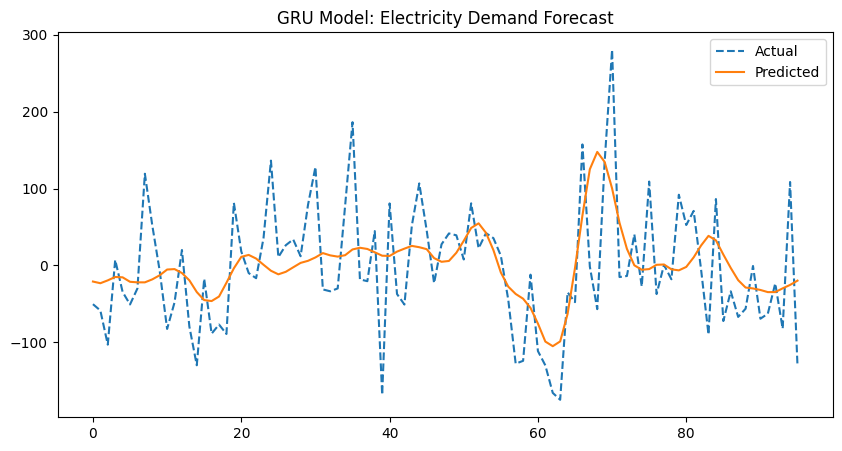

In [38]:
# Move tensors to CPU and convert to NumPy arrays
y_batch_cpu = y_batch.cpu().numpy()
y_pred_cpu = y_pred.cpu().numpy()

# Now plot the data
plt.figure(figsize=(10, 5))
plt.plot(y_batch_cpu[0], label="Actual", linestyle="dashed")
plt.plot(y_pred_cpu[0], label="Predicted")
plt.legend()
plt.title("GRU Model: Electricity Demand Forecast")
plt.show()


In [39]:

# Convert to numpy array
ts_diff1_array = ts_diff1.values.reshape(-1, 1)  # Ensure it's a 2D array

# Define past and future windows
past_window = 14 * 96  # Past 7 days (96 timestamps per day)
future_window = 96    # Predict next 24 hours (96 timestamps)

# Function to create sequences
def create_sequences(data, past_window, future_window):
    X, y = [], []
    for i in range(len(data) - past_window - future_window):
        X.append(data[i:i + past_window])   # Past 7 days
        y.append(data[i + past_window:i + past_window + future_window])  # Next 96 timestamps
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(ts_diff1_array, past_window, future_window)

print("Shape of X:", X.shape)  # (samples, 672, 1)
print("Shape of y:", y.shape)  # (samples, 96, 1)


Shape of X: (260859, 1344, 1)
Shape of y: (260859, 96, 1)


In [41]:
train_size = int(0.8 * len(X))  
val_size = int(0.1 * len(X))   
test_size = len(X) - train_size - val_size  

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (208687, 1344, 1) (208687, 96, 1)
Validation: (26085, 1344, 1) (26085, 96, 1)
Test: (26087, 1344, 1) (26087, 96, 1)


In [42]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)


In [43]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [44]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [45]:
# Convert NumPy arrays to PyTorch tensors (without squeezing)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device).squeeze(-1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze(-1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device).squeeze(-1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze(-1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device).squeeze(-1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).squeeze(-1).to(device)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [46]:
import torch.nn as nn
import torch.optim as optim

class BiLSTMModel(nn.Module):
    def __init__(self):
        super(BiLSTMModel, self).__init__()
        # BiLSTM layer with bidirectional=True
        self.bilstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128 * 2, 64)  # 128 * 2 because the LSTM is bidirectional
        self.fc2 = nn.Linear(64, 96)

    def forward(self, x):
        # Pass through BiLSTM
        bilstm_out, _ = self.bilstm(x)
        last_output = bilstm_out[:, -1, :]  # Get the last output
        x = self.fc1(last_output)
        x = self.fc2(x)
        return x

model = BiLSTMModel().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


BiLSTMModel(
  (bilstm): LSTM(1, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=96, bias=True)
)


In [ ]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensure shape (batch_size, 672, 1)
        y_batch = y_batch.squeeze(-1)  # Ensure shape (batch_size, 96)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.unsqueeze(-1)
            y_batch = y_batch.squeeze(-1)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/20, Train Loss: 4451.9646, Val Loss: 6027.6586
Epoch 2/20, Train Loss: 4444.6167, Val Loss: 5570.3329
Epoch 3/20, Train Loss: 4135.9552, Val Loss: 5164.3036
Epoch 4/20, Train Loss: 4028.5709, Val Loss: 5341.2360
Epoch 5/20, Train Loss: 4209.5320, Val Loss: 5372.4061
Epoch 6/20, Train Loss: 4098.9898, Val Loss: 6074.8483
Epoch 7/20, Train Loss: 4410.1689, Val Loss: 6058.4327


In [31]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,  # Save the current epoch
    'loss': loss,  # Save the last loss
}

torch.save(checkpoint, "model_checkpoint.pth")